In [1]:
!pip install --upgrade google-cloud-bigquery

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from google.cloud import bigquery as bq

In [3]:
%%bigquery
SELECT
  DISTINCT(FL_DATE) AS FL_DATE
FROM
  `flights.tzcorr`
ORDER BY
  FL_DATE

Downloading: 100%|██████████| 365/365 [00:00<00:00, 400.07rows/s]


,FL_DATE
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
...,...
360,2015-12-27
361,2015-12-28
362,2015-12-29
363,2015-12-30


In [4]:
%%bigquery
SELECT
  FL_DATE,
  IF(MOD(ABS(FARM_FINGERPRINT(CAST(FL_DATE AS STRING))), 100) < 70,
     'True', 'False') AS is_train_day
FROM (
  SELECT
    DISTINCT(FL_DATE) AS FL_DATE
  FROM
    `flights.tzcorr`)
ORDER BY
  FL_DATE

Downloading: 100%|██████████| 365/365 [00:01<00:00, 337.53rows/s]


,FL_DATE,is_train_day
0,2015-01-01,True
1,2015-01-02,False
2,2015-01-03,False
3,2015-01-04,True
4,2015-01-05,True
...,...,...
360,2015-12-27,False
361,2015-12-28,True
362,2015-12-29,True
363,2015-12-30,True


In [5]:
depdelayquery3 = """
SELECT
  *
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'True'
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""

In [6]:
%%bigquery depdelay
SELECT
  DEP_DELAY,
  arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY

Downloading: 100%|██████████| 240/240 [00:00<00:00, 244.54rows/s]


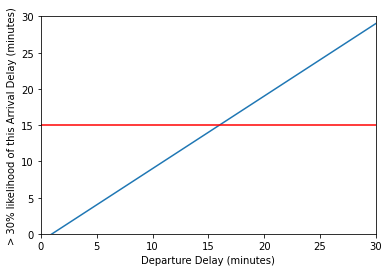

In [7]:
import matplotlib.pyplot as plt

ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
    ax=ax, ylim=(0,30), xlim=(0,30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)')
plt.axhline(y=15, color='r');

In [8]:
%%bigquery eval
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False')

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.13s/rows]


In [9]:
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,1259740,66081,52827,217669


In [10]:
print (eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel']))
print (eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel']))

0    0.950158
dtype: float64
0    0.804703
dtype: float64


In [11]:
%%bigquery eval
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False')

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.01rows/s]


In [12]:
eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,7684,2935,6787,2942


In [13]:
print (eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel']))
print (eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel']))

0    0.723609
dtype: float64
0    0.302395
dtype: float64
